# Biodiversity in National Parks

The Codecademy Off-Platform Project on significance testing and calculating sample size for an experiment. The data is enspired by US National Parks Service, but is mostly fictional. 

Analysis will include:
- investigating whether there are any patterns or themes to the types of species that become endangered
- calculating how many weeks it would take to observe enough sheeps for the expetiment of reducing the rate of foot and mouth disease at that park

## Import Python modules and the Dataset

In [3]:
from matplotlib import pyplot as plt
import pandas as pd

`species_info.csv` has data about different species in our National Parks, including:
- The scientific name of each species
- The common names of each species
- The species conservation status

In [4]:
species = pd.read_csv('species_info.csv')

In [5]:
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


## Inspecting data

How many different species are in the `species` DataFrame?

In [6]:
len(species)

5824

What are the different values of `category` in `species`?

In [7]:
species.describe()

,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Castor canadensis,Dicranum Moss,Species of Concern
freq,4470,3,7,161


What are the different values of `conservation_status`?

In [8]:
species.conservation_status.unique()

array([nan, 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

## How many species in each conservation status?

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currnetly neither in danger of extinction throughout all or a significant portion of its range

In [9]:
species.groupby('conservation_status')['scientific_name'].count()

conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
Name: scientific_name, dtype: int64

As we saw before, there are far more than 200 species in the `species` table.  Clearly, only a small number of them are categorized as needing some sort of protection.  The rest have `conservation_status` equal to `None`.  Because `groupby` does not include `None`, we will need to fill in the null values.

In [10]:
species.fillna('No Intervention', inplace=True)

In [11]:
species.groupby('conservation_status')['scientific_name'].count()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
Name: scientific_name, dtype: int64

### Visulasing conservation status

In [12]:
#create new dataframe
protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')

protection_counts.head()

,conservation_status,scientific_name
1,In Recovery,4
4,Threatened,10
0,Endangered,15
3,Species of Concern,151
2,No Intervention,5363


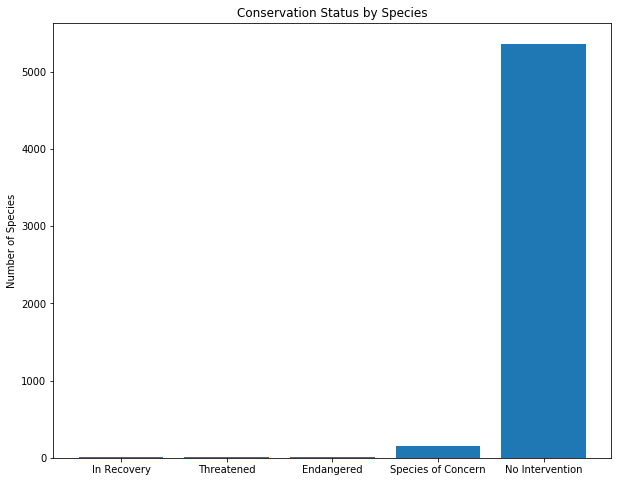

In [16]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()

plt.bar(range(len(protection_counts)), protection_counts['scientific_name'])
ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts.conservation_status.values)
plt.ylabel('Number of Species')
plt.title('Conservation Status by Species')
plt.show()

Since there a so much more species in 'No intervention group', bar chart does not tell us that much. Interactive pie chart could visualize the data better.

In [18]:
import plotly.express as px

fig = px.pie(protection_counts, values='scientific_name', names='conservation_status')
fig.show()

## Are certain types of species more likely to be endangered?

In [21]:
species['is_protected'] = species.conservation_status != 'No Intervention'

In [22]:
category_counts = species.groupby(['category', 'is_protected'])\
                         .scientific_name.nunique().reset_index()
category_counts

,category,is_protected,scientific_name
0,Amphibian,False,72
1,Amphibian,True,7
2,Bird,False,413
3,Bird,True,75
4,Fish,False,115
5,Fish,True,11
6,Mammal,False,146
7,Mammal,True,30
8,Nonvascular Plant,False,328
9,Nonvascular Plant,True,5


It's going to be easier to view this data if we pivot it.

In [24]:
category_pivot = category_counts.pivot(index='category', values='scientific_name', columns='is_protected').reset_index()
category_pivot

is_protected,category,False,True
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [26]:
# rename the categories `True` and `False` to something more description
category_pivot.columns = ['category', 'not_protected', 'protected']

In [27]:
# calculate percentage of protected spicies
category_pivot['percent_protected'] = category_pivot['protected'] / (category_pivot['protected'] + category_pivot['not_protected'])
category_pivot

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,0.088608
1,Bird,413,75,0.153689
2,Fish,115,11,0.087302
3,Mammal,146,30,0.170455
4,Nonvascular Plant,328,5,0.015015
5,Reptile,73,5,0.064103
6,Vascular Plant,4216,46,0.010793


It looks like species in category `Mammal` are more likely to be endangered than species in `Bird`.  We're going to do a significance test to see if this statement is true.  Before you do the significance test, consider the following questions:
- Is the data numerical or categorical?
- How many pieces of data are you comparing?

Since data is categorical and we have a contingency table we can perform a *chi squared test*.

In [70]:
contingency = [[30, 146],
              [75, 413]]

In [71]:
from scipy.stats import chi2_contingency

In [72]:
chi2_contingency(contingency)

(0.1617014831654557, 0.6875948096661336, 1, array([[ 27.8313253, 148.1686747],
        [ 77.1686747, 410.8313253]]))

It looks like this difference isn't significant!

Let's test another.  Is the difference between `Reptile` and `Mammal` significant?

In [75]:
contingency2 = [[30, 146],
              [5, 73]]
chi2_contingency(contingency2)

(4.289183096203645, 0.03835559022969898, 1, array([[ 24.2519685, 151.7480315],
        [ 10.7480315,  67.2519685]]))

Yes! It looks like there is a significant difference between `Reptile` and `Mammal`!

## Analyze sightings of different species

Conservationists have been recording sightings of different species at several national parks for the past 7 days.  They've saved sent you their observations in a file called `observations.csv`.

In [77]:
observations = pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


Some scientists are studying the number of sheep sightings at different national parks.  There are several different scientific names for different types of sheep.  We'd like to know which rows of `species` are referring to sheep. 

In [85]:
species['is_sheep'] = species.common_names.apply(lambda x: 'Sheep' in x)

species.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False


Select the rows of `species` where `is_sheep` is `True` and examine the results.

In [86]:
species[species.is_sheep]

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
1139,Vascular Plant,Rumex acetosella,"Sheep Sorrel, Sheep Sorrell",No Intervention,False,True
2233,Vascular Plant,Festuca filiformis,Fineleaf Sheep Fescue,No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3758,Vascular Plant,Rumex acetosella,"Common Sheep Sorrel, Field Sorrel, Red Sorrel,...",No Intervention,False,True
3761,Vascular Plant,Rumex paucifolius,"Alpine Sheep Sorrel, Fewleaved Dock, Meadow Dock",No Intervention,False,True
4091,Vascular Plant,Carex illota,"Sheep Sedge, Smallhead Sedge",No Intervention,False,True
4383,Vascular Plant,Potentilla ovina var. ovina,Sheep Cinquefoil,No Intervention,False,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


Many of the results are actually plants. 

In [87]:
sheep_species = species[(species.is_sheep) & (species.category == 'Mammal')]

In [88]:
#merge sheep_species with observations to get a DataFrame with observations of sheep
sheep_observations = observations.merge(sheep_species)
sheep_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_sheep
0,Ovis canadensis,Yellowstone National Park,219,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
1,Ovis canadensis,Bryce National Park,109,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
2,Ovis canadensis,Yosemite National Park,117,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3,Ovis canadensis,Great Smoky Mountains National Park,48,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4,Ovis canadensis sierrae,Yellowstone National Park,67,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
5,Ovis canadensis sierrae,Yosemite National Park,39,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
6,Ovis canadensis sierrae,Bryce National Park,22,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
7,Ovis canadensis sierrae,Great Smoky Mountains National Park,25,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
8,Ovis aries,Yosemite National Park,126,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
9,Ovis aries,Great Smoky Mountains National Park,76,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True


How many total sheep observations (across all three species) were made at each national park? 

In [91]:
obs_by_park = sheep_observations.groupby('park_name')['observations'].sum().reset_index()
obs_by_park

,park_name,observations
0,Bryce National Park,250
1,Great Smoky Mountains National Park,149
2,Yellowstone National Park,507
3,Yosemite National Park,282


### Bar chart showing the different number of observations per week at each park

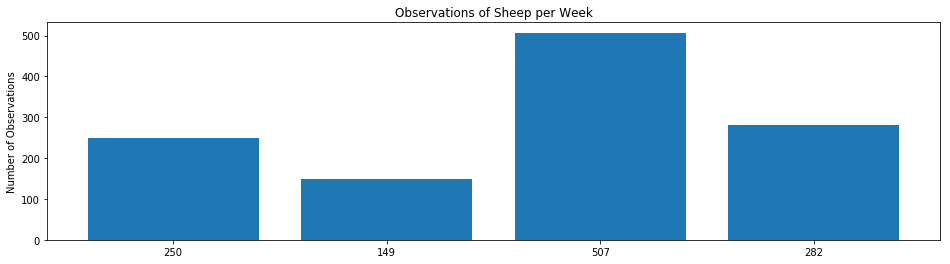

In [92]:
plt.figure(figsize=(16, 4))
ax = plt.subplot()

plt.bar(range(len(obs_by_park)), obs_by_park['observations'])
ax.set_xticks(range(len(obs_by_park)))
ax.set_xticklabels(obs_by_park['observations'].values)
plt.ylabel('Number of Observations')
plt.title('Observations of Sheep per Week')
plt.show()

Our scientists know that 15% of sheep at Bryce National Park have foot and mouth disease.  Park rangers at Yellowstone National Park have been running a program to reduce the rate of foot and mouth disease at that park.  The scientists want to test whether or not this program is working.  They want to be able to detect reductions of at least 5 percentage points.  For instance, if 10% of sheep in Yellowstone have foot and mouth disease, they'd like to be able to know this, with confidence.

Use <a href="https://s3.amazonaws.com/codecademy-content/courses/learn-hypothesis-testing/a_b_sample_size/index.html">Codecademy's sample size calculator</a> to calculate the number of sheep that they would need to observe from each park.  Use the default level of significance (90%).

In [ ]:
minimum_detectable_effect = 100 * 0.05 / 0.15
baseline = 15
sample_size_per_variant = 870

How many weeks would you need to observe sheep at Bryce National Park in order to observe enough sheep?  How many weeks would you need to observe at Yellowstone National Park to observe enough sheep?

In [5]:
bryce = 870 / 250
yellowstone = 810 / 507
print('It takes approximately',round(bryce,2),'weeks to observe sheep at Bryce National Park')
print('It takes approximately',round(yellowstone,2),'weeks to observe sheep at Yellowstone National Park')

It takes approximately 3.48 weeks to observe sheep at Bryce National Park
It takes approximately 1.6 weeks to observe sheep at Yellowstone National Park
